In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings('ignore')

sns.set()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving book_tags.csv to book_tags.csv
Saving books.csv to books.csv
Saving ratings.csv to ratings.csv
Saving tags.csv to tags.csv


# EDA

In the Data Set from Kaggle we will use ratings.csv, books.csv, book_tags.csv, tags.csv.

In [ ]:
books = pd.read_csv('books.csv')
book_tags = pd.read_csv('book_tags.csv')
ratings= pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

따로 귀찮아서 형태는 보여 주지 않았지만 간단 요약

-ratings.csv contains all users’s ratings of the books (a total of 980k ratings, for 10,000 books, from 53,424 users)

-books.csv contains more information on the books such as author, year, etc. 

-book_tags contains all tag_ids users have assigned to that books and corresponding tag_counts

-tags.csv contains the tag_names corresponding to the tag_ids.

**Cleaning**

The Data of book.csv had problem like some combinations of user and book there are multiple ratings

Furthermore, for the collaborative filtering it is better to have more ratings per user. So in this part also remove users who have rated fewer than 3 books.

복수 레이팅 제외, 책 3개 미만 레이팅한 유저들 제외

In [ ]:
ratings_rmv_duplicates = ratings.drop_duplicates()
unwanted_users = ratings_rmv_duplicates.groupby('user_id')['user_id'].count()
unwanted_users = unwanted_users[unwanted_users < 3]
unwanted_ratings = ratings_rmv_duplicates[ratings_rmv_duplicates.user_id.isin(unwanted_users.index)]
new_ratings = ratings_rmv_duplicates.drop(unwanted_ratings.index)

In [ ]:
new_ratings['title'] = books.set_index('id').title.loc[new_ratings.book_id].values

**Explore**

1. Distribution of Ratings

People tend to give quite positive ratings to books. Most of the ratings are in the 3-5 range, while very few ratings are in the 1-2 range.

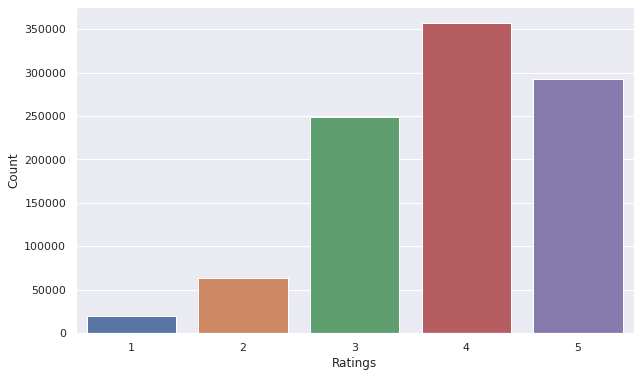

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data = ratings, x = 'rating')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

2. Number of ratings per user

In this case I selected only a subset of users for less calculation

In [ ]:
ratings_sample = ratings_rmv_duplicates.sample(frac=0.3)
ratings_sample.shape

(294034, 3)

In [ ]:
ratings_per_user = ratings_sample.groupby('user_id')['user_id'].count()

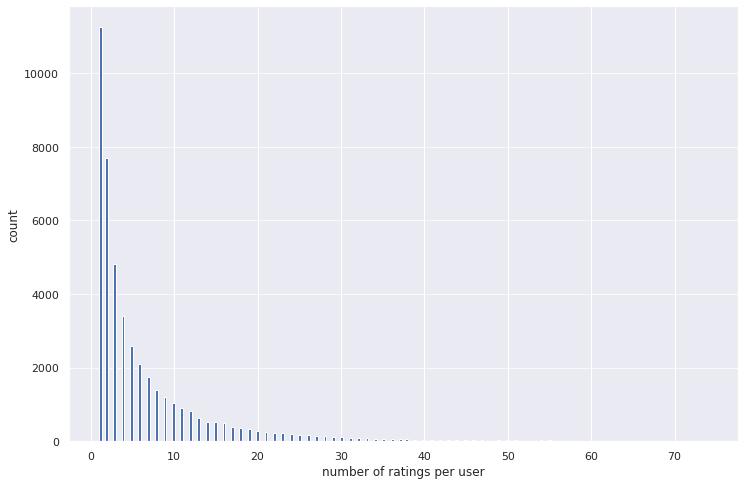

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(ratings_per_user ,bins='auto');
plt.grid(axis='y', alpha=0.75)
plt.xlabel('number of ratings per user')
plt.ylabel('count');

3. Distribution of mean user ratings

People have different tendencies to rate books.

We can also see that there are nearly no notoriuous downvoters rating all books with a 1. 

In [ ]:
mean_rating_per_user = ratings_sample.groupby('user_id')['rating'].mean()

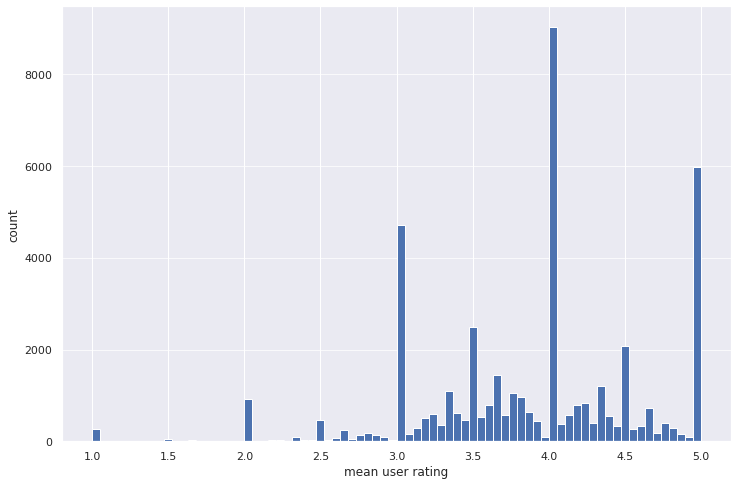

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(mean_rating_per_user, bins='auto');
plt.grid(axis='y', alpha=0.75)
plt.xlabel('mean user rating')
plt.ylabel('count');

4. Number of ratings per book

Subsetted dataset most books have around 30 ratings.

In [ ]:
ratings_per_book = ratings_sample.groupby('book_id')['book_id'].count()

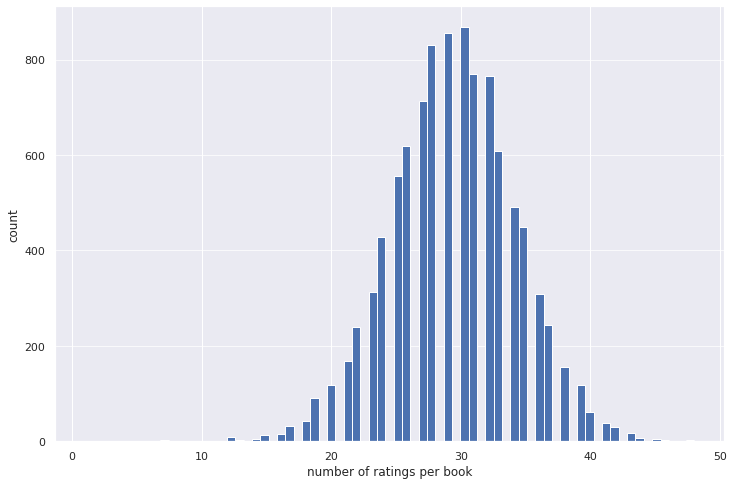

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(ratings_per_book ,bins='auto');
plt.grid(axis='y', alpha=0.75)
plt.xlabel('number of ratings per book')
plt.ylabel('count');

**Correlation**

Do frequent raters rate differently?

In [ ]:
jp = sns.jointplot(x=ratings.groupby('user_id')['user_id'].count(),
                   y=ratings.groupby('user_id')['rating'].mean(),
                   kind='reg', line_kws={'color':'cyan'})
jp.annotate(stats.pearsonr, fontsize=12);
plt.xlabel('number_of_rated_books');
plt.ylabel('mean_rating');

Users that rate more books (frequent raters) rate books differently from less frequent raters.

이 부분을 넣은 이유는 결국 rating을 3명 미만으로 한 유저들을 빼는 이유를 설명한다

figure 같은 경우는 코드를 돌리면 annotate가 업데이트가 되면서 누락이 되었기에 피어슨 상관계수가 나오지 않는다 

해결 방법은 찾기가 싫어서 참고한 사이트의 figure를 그대로 가져옴

The figure below explores this possibility. It seems like frequent raters tend to give lower ratings to books, maybe they are/become more critical the more they read and rate.

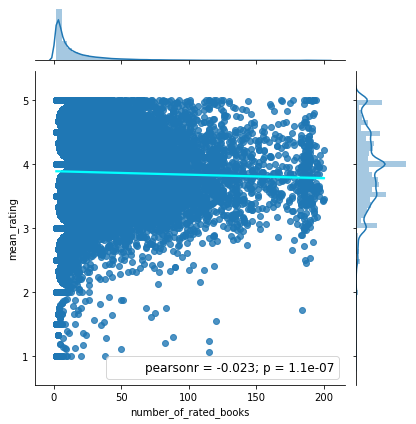

we see only small correlations between the features and the average rating, indicating that there are no strong relationships between the rating a book receives and meta-variables (like rating counts etc.). This means that the rating depends more strongly on other features (e.g. the quality of the books itself).

In [ ]:
cols = ['books_count','original_publication_year','average_rating','ratings_count','work_ratings_count','work_text_reviews_count']

In [ ]:
corr = books[cols].corr()

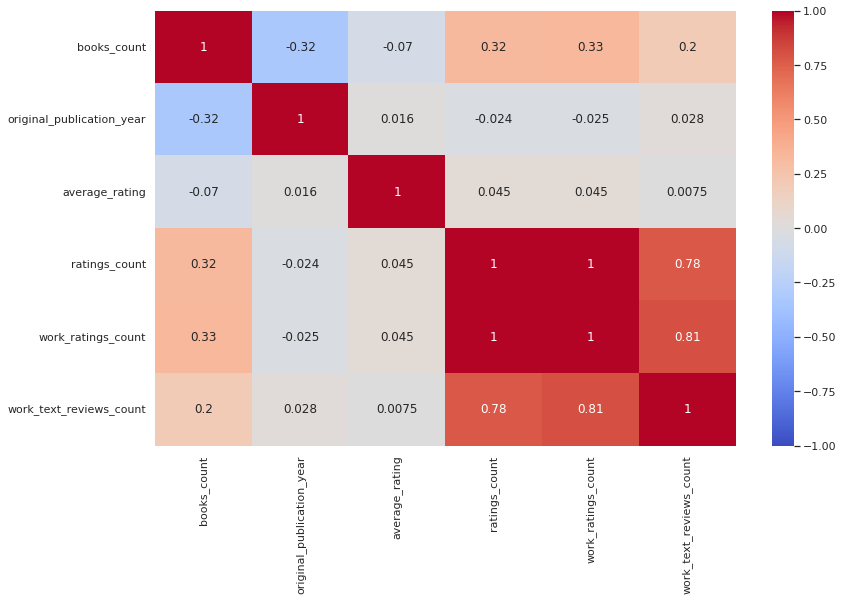

In [ ]:
plt.figure(figsize=(13,8))
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', annot=True);

# Content Based Filtering

*더 자세한 내용은 교수님의 피피티나 구글링하세요*

아이템 자체를 분석하여 추천을 구현함

아이템 분석 및 유사도 측정이 핵심이다

**Based on book's Title, Authors and Genres.**

Strip Spaces and Convert to Lowercase from authors

Combining books with their corresponding genres

Use a Count Vectorizer to create our count matrix.

Use the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two books.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [ ]:
books['authors'] = books['authors'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x.split(', ')])

In [ ]:
def get_genres(x):
    t = book_tags[book_tags.goodreads_book_id==x]
    return [i.lower().replace(" ", "") for i in tags.tag_name.loc[t.tag_id].values]

In [ ]:
books['genres'] = books.book_id.apply(get_genres)

In [ ]:
books['soup'] = books.apply(lambda x: ' '.join([x['title']] + x['authors'] + x['genres']), axis=1)

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(books['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
indices = pd.Series(books.index, index=books['title'])
titles = books['title']

In [ ]:
def get_recommendations(title, n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    book_indices = [i[0] for i in sim_scores]
    return list(titles.iloc[book_indices].values)[:n]

In [ ]:
get_recommendations('1984')

['Brave New World',
 'Fahrenheit 451',
 'Animal Farm',
 'Lord of the Flies',
 'Slaughterhouse-Five',
 'A Clockwork Orange',
 'Frankenstein',
 'The Picture of Dorian Gray',
 'The Invisible Man',
 'The Catcher in the Rye']

**Popularity and Ratings**

어떤 유명한 작가의 작품 중에서도 명작이 있고 졸작이 있다. 내가 좋아하는 작가이더라도 졸작은 좋아하지 않을 가능성이 높다. 하지만 위와 같은 방식의 CBF는 그걸 구별하지 못한다 그래서 평가가 좋지 않는 작품들을 제외하고 효평 받고 유명한 작품들을 추천하는 시스템을 구현해 봤다.


Used IMDB's weighted rating formula to recommend

v is the number of ratings for the book

m is the minimum ratings required to be listed in the chart

R is the average rating of the book

C is the mean rating across the whole report



W = (R*v + C*m) / (v + m)는 계산식이다

In [ ]:
v = books['ratings_count']
m = books['ratings_count'].quantile(0.95)
R = books['average_rating']
C = books['average_rating'].mean()
W = (R*v + C*m) / (v + m)

In [ ]:
books['weighted_rating'] = W

In [ ]:
def improved_recommendations(title, n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    book_indices = [i[0] for i in sim_scores]
    df = books.iloc[book_indices][['title', 'ratings_count', 'average_rating', 'weighted_rating']]

    v = df['ratings_count']
    m = df['ratings_count'].quantile(0.60)
    R = df['average_rating']
    C = df['average_rating'].mean()
    df['weighted_rating'] = (R*v + C*m) / (v + m)
    
    qualified = df[df['ratings_count'] >= m]
    qualified = qualified.sort_values('weighted_rating', ascending=False)
    return qualified.head(n)

In [ ]:
improved_recommendations("1984")

,title,ratings_count,average_rating,weighted_rating
3,To Kill a Mockingbird,3198671,4.25,4.193522
9,Pride and Prejudice,2035490,4.24,4.161114
64,Slaughterhouse-Five,846488,4.06,3.993220
54,Brave New World,1022601,3.97,3.944341
4,The Great Gatsby,2683664,3.89,3.892251
13,Animal Farm,1881700,3.87,3.877928
31,Of Mice and Men,1467496,3.84,3.858408
82,A Tale of Two Cities,637412,3.81,3.855352
62,Wuthering Heights,899195,3.82,3.853455
7,The Catcher in the Rye,2044241,3.79,3.816054


Limits

It is only capable of suggesting books which are close to a certain book.

It is not capable of capturing tastes and providing recommendations across genres

It doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a book will receive the same recommendations



# Collaborative Filtering

뻔한 내용

Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not

Use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE

SVD is similar to eigendecomposition(고유값 분해)

https://darkpgmr.tistory.com/106 더 자세한 설명

User-based, which measures the similarity between target users and other users.

Item-based, which measures the similarity between the items that target users rate or interact with and other items.

User-based 기반으로 CF를 학습했습니다.

# User-based CF

In [ ]:
! pip install surprise

     |████████████████████████████████| 11.8 MB 5.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633714 sha256=4e05089ccd06a319c9c3274214da651310fce9f84c15786d6bb7e9714ee84744
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [ ]:
reader = Reader()
data = Dataset.load_from_df(new_ratings[['user_id', 'book_id', 'rating']], reader)

Root Mean Sqaure Error of about 0.84

In [ ]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'fit_time': (73.70253086090088,
  63.8881151676178,
  58.74323844909668,
  57.28773236274719,
  57.790958404541016),
 'test_mae': array([0.65887957, 0.65986691, 0.65750651, 0.66036934, 0.65550331]),
 'test_rmse': array([0.84223084, 0.84432961, 0.84155493, 0.84528295, 0.83836908]),
 'test_time': (2.917358636856079,
  2.3211865425109863,
  2.6808743476867676,
  2.765547513961792,
  2.8350396156311035)}

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset);

In [ ]:
new_ratings[new_ratings['user_id'] ==500]

,book_id,user_id,rating,title
307156,3075,500,3,"Twilight: The Graphic Novel, Vol. 1 (Twilight:..."
698651,7029,500,4,I Want My Hat Back
782059,7886,500,4,By the Sword (Valdemar)
782753,7893,500,4,"Arrow's Fall (Heralds of Valdemar, #3)"
802965,8103,500,4,"Arrow's Flight (Heralds of Valdemar, #2)"
842437,8515,500,5,This Time Together: Laughter and Reflection
907809,9201,500,3,Love Bites (Argeneau #2)
943571,9589,500,5,Scaredy Squirrel (Scaredy Squirrel)


In [ ]:
new_ratings[new_ratings['user_id'] == 200]

,book_id,user_id,rating,title
461526,4625,200,3,Twenty-Eight and a Half Wishes (Rose Gardner M...
573970,5762,200,4,Abducted (Lizzy Gardner #1)
636423,6393,200,3,Chicken Soup for the Teenage Soul: 101 Stories...
720137,7249,200,3,Vagabonding: An Uncommon Guide to the Art of L...
813882,8218,200,3,There's a Boy in the Girls' Bathroom
819139,8273,200,3,The Orchid House
873158,8836,200,5,True Compass: A Memoir
976522,9944,200,4,Give and Take: A Revolutionary Approach to Suc...


In [ ]:
svd.predict(200, 4625)

Prediction(uid=200, iid=4625, r_ui=None, est=3.293878927403157, details={'was_impossible': False})

For book with ID 4625, we get an estimated prediction of 3.293. 

It works purely on the basis of an assigned book ID and tries to predict ratings based on how the other users have predicted the book

# Hybrid

Input: User ID and the Title of a Book

Output: Similar books sorted on the basis of expected ratings by that particular user.

In [ ]:
def hybrid(user_id, title, n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:51]
    book_indices = [i[0] for i in sim_scores]
    
    df = books.iloc[book_indices][['book_id', 'title', 'original_publication_year', 'ratings_count', 'average_rating']]
    df['est'] = df['book_id'].apply(lambda x: svd.predict(user_id, x).est)
    df = df.sort_values('est', ascending=False)
    return df.head(n)

In [ ]:
hybrid(500, 'A Game of Thrones (A Song of Ice and Fire, #1)')

,book_id,title,original_publication_year,ratings_count,average_rating,est
109,10572,"A Clash of Kings (A Song of Ice and Fire, #2)",1998.0,523303,4.40,3.879434
3577,104089,Tigana,1990.0,30831,4.12,3.879434
7299,17345242,The World of Ice & Fire: The Untold History of...,2014.0,12119,4.25,3.879434
329,228665,"The Eye of the World (Wheel of Time, #1)",1990.0,260184,4.18,3.879434
561,7235533,"The Way of Kings (The Stormlight Archive, #1)",2010.0,144822,4.64,3.879434
1904,13569581,"Blood Song (Raven's Shadow, #1)",2011.0,44014,4.47,3.879434
1355,3428935,"The Warded Man (Demon Cycle, #1)",2008.0,64416,4.27,3.879434
5253,341735,Replay,1986.0,18019,4.16,3.879434
1510,21535271,The Slow Regard of Silent Things (The Kingkill...,2014.0,57716,3.92,3.879434
321,14497,Neverwhere,1996.0,268318,4.18,3.879434


In [ ]:
hybrid(200, 'A Game of Thrones (A Song of Ice and Fire, #1)')

,book_id,title,original_publication_year,ratings_count,average_rating,est
109,10572,"A Clash of Kings (A Song of Ice and Fire, #2)",1998.0,523303,4.40,3.723149
3577,104089,Tigana,1990.0,30831,4.12,3.723149
7299,17345242,The World of Ice & Fire: The Untold History of...,2014.0,12119,4.25,3.723149
329,228665,"The Eye of the World (Wheel of Time, #1)",1990.0,260184,4.18,3.723149
561,7235533,"The Way of Kings (The Stormlight Archive, #1)",2010.0,144822,4.64,3.723149
1904,13569581,"Blood Song (Raven's Shadow, #1)",2011.0,44014,4.47,3.723149
1355,3428935,"The Warded Man (Demon Cycle, #1)",2008.0,64416,4.27,3.723149
5253,341735,Replay,1986.0,18019,4.16,3.723149
1510,21535271,The Slow Regard of Silent Things (The Kingkill...,2014.0,57716,3.92,3.723149
321,14497,Neverwhere,1996.0,268318,4.18,3.723149


we get (almost) different recommendations for different users although the book is the same

**Improved Version**

Use our improved_recommendations technique, that we used in the Content Based seciton above

Combine it with the user estimations, by dividing their summation by 2
Finally, put the result into a new feature score

In [ ]:
def improved_hybrid(user_id, title, n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:51]
    book_indices = [i[0] for i in sim_scores]
    
    df = books.iloc[book_indices][['book_id', 'title', 'ratings_count', 'average_rating', 'original_publication_year']]
    v = df['ratings_count']
    m = df['ratings_count'].quantile(0.60)
    R = df['average_rating']
    C = df['average_rating'].mean()
    df['weighted_rating'] = (R*v + C*m) / (v + m)
    
    df['est'] = df['book_id'].apply(lambda x: svd.predict(user_id, x).est)
    
    df['score'] = (df['est'] + df['weighted_rating']) / 2
    df = df.sort_values('score', ascending=False)
    return df[['book_id', 'title', 'original_publication_year', 'ratings_count', 'average_rating', 'score']].head(n)

In [ ]:
improved_hybrid(500, 'A Game of Thrones (A Song of Ice and Fire, #1)')

,book_id,title,original_publication_year,ratings_count,average_rating,score
861,17332218,"Words of Radiance (The Stormlight Archive, #2)",2014.0,73572,4.77,4.195705
561,7235533,"The Way of Kings (The Stormlight Archive, #1)",2010.0,144822,4.64,4.194688
191,186074,The Name of the Wind (The Kingkiller Chronicle...,2007.0,400101,4.55,4.191718
134,62291,"A Storm of Swords (A Song of Ice and Fire, #3)",2000.0,469022,4.54,4.190316
306,1215032,"The Wise Man's Fear (The Kingkiller Chronicle,...",2011.0,245686,4.57,4.188281
602,2767793,"The Hero of Ages (Mistborn, #3)",2008.0,143622,4.46,4.134585
1495,147915,A Storm of Swords: Blood and Gold (A Song of I...,2000.0,54977,4.56,4.131723
388,68428,"The Final Empire (Mistborn, #1)",2006.0,208944,4.43,4.131605
109,10572,"A Clash of Kings (A Song of Ice and Fire, #2)",1998.0,523303,4.40,4.130625
1373,7743175,"A Memory of Light (Wheel of Time, #14)",2012.0,68410,4.50,4.125557


In [ ]:
improved_hybrid(200, 'A Game of Thrones (A Song of Ice and Fire, #1)')

,book_id,title,original_publication_year,ratings_count,average_rating,score
861,17332218,"Words of Radiance (The Stormlight Archive, #2)",2014.0,73572,4.77,4.117562
561,7235533,"The Way of Kings (The Stormlight Archive, #1)",2010.0,144822,4.64,4.116545
191,186074,The Name of the Wind (The Kingkiller Chronicle...,2007.0,400101,4.55,4.113576
134,62291,"A Storm of Swords (A Song of Ice and Fire, #3)",2000.0,469022,4.54,4.112173
306,1215032,"The Wise Man's Fear (The Kingkiller Chronicle,...",2011.0,245686,4.57,4.110139
602,2767793,"The Hero of Ages (Mistborn, #3)",2008.0,143622,4.46,4.056442
1495,147915,A Storm of Swords: Blood and Gold (A Song of I...,2000.0,54977,4.56,4.053580
388,68428,"The Final Empire (Mistborn, #1)",2006.0,208944,4.43,4.053463
109,10572,"A Clash of Kings (A Song of Ice and Fire, #2)",1998.0,523303,4.40,4.052483
1373,7743175,"A Memory of Light (Wheel of Time, #14)",2012.0,68410,4.50,4.047415


The new results make more sense, besides to, the recommendations are more personalized and tailored towards particular users.